In [ ]:
#@title **Information**
%%html
<marquee style='width: 50%; color: white;'><b>Dylan Govender (221040222) - COMP700</b></marquee>

# **1. Importing the data.**

In [ ]:
!cp '/content/drive/MyDrive/Honours Project/Datasets/IQ-OTHNCCD_Lung_Cancer_Dataset.zip' 'IQ-OTHNCCD_Lung_Cancer_Dataset.zip'

In [ ]:
%%capture
!unzip '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'
!rm '/content/IQ-OTHNCCD_Lung_Cancer_Dataset.zip'

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

normal_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Normal cases"
benign_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Bengin cases"
malignant_dir = "/content/The IQ-OTHNCCD lung cancer dataset/Malignant cases"
dir = [normal_dir, benign_dir, malignant_dir]

class_labels = ['benign', 'malignant', 'normal']

labels = []
filepaths = []

for i, directory in enumerate(dir):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        filepaths.append(filepath)
        labels.append(class_labels[i])

file_series = pd.Series(filepaths, name="filepaths")
label_series = pd.Series(labels, name="labels")
lung_data = pd.concat([file_series, label_series], axis=1)
lung_df = pd.DataFrame(lung_data)
lung_df.head()

,filepaths,labels
0,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
1,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
2,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
3,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign
4,/content/The IQ-OTHNCCD lung cancer dataset/No...,benign


In [ ]:
print(lung_df["labels"].value_counts())
print("SHAPE:", lung_df.shape)

labels
normal       561
benign       416
malignant    120
Name: count, dtype: int64
SHAPE: (1097, 2)


## **1.1 Plot Lung Cancer Distribution Graph**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SIZE = (8, 4)

In [ ]:
def plot_distribution(df, attribute, title, x_label, y_label, size=SIZE):
    # set a seaborn style for a more polished look
    sns.set_style("whitegrid")

    # adjust figure size
    plt.figure(figsize=size)

    # create the count plot with enhanced color palette and edge color
    sns.countplot(x=attribute, data=df, hue=attribute, palette="viridis", edgecolor='black', legend=False)

    # set labels and title with customized font sizes
    plt.xlabel(x_label, fontsize=14, fontweight='bold')
    plt.ylabel(y_label, fontsize=14, fontweight='bold')
    plt.title(title, fontsize=18, fontweight='bold')

    # improve the layout
    plt.tight_layout()

    # show the plot
    plt.show()

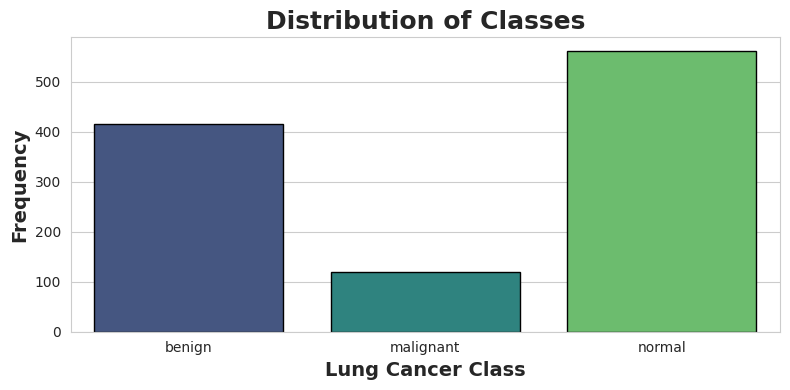

In [ ]:
attribute = 'labels'
title = 'Distribution of Classes'
x_label = 'Lung Cancer Class'
y_label = 'Frequency'

plot_distribution(lung_df, attribute, title, x_label, y_label)

# **2. Preprocessing the data.**

In [ ]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

train_set, remaining = train_test_split(lung_df, test_size=0.4, random_state=42)
test_set, val_set = train_test_split(remaining, test_size=0.5, random_state=42)

data = [
    ["Train", train_set.shape],
    ["Test", test_set.shape],
    ["Validate", val_set.shape],
]

X_table = tabulate(data, headers=["SETS", "Shape"], tablefmt="fancy_grid")
print(X_table)

╒══════════╤══════════╕
│ SETS     │ Shape    │
╞══════════╪══════════╡
│ Train    │ (658, 2) │
├──────────┼──────────┤
│ Test     │ (219, 2) │
├──────────┼──────────┤
│ Validate │ (220, 2) │
╘══════════╧══════════╛


In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# slightly smaller resize
IMG_HEIGHT = 244
IMG_WIDTH = 244
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 4

image_generator = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input
)

train = image_generator.flow_from_dataframe(
    dataframe=train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test = image_generator.flow_from_dataframe(
    dataframe=test_set,
    x_col="filepaths",
    y_col="labels",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

val = image_generator.flow_from_dataframe(
    dataframe=val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 658 validated image filenames belonging to 3 classes.
Found 219 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
classes = list(train.class_indices.keys())
print(classes)

['benign', 'malignant', 'normal']


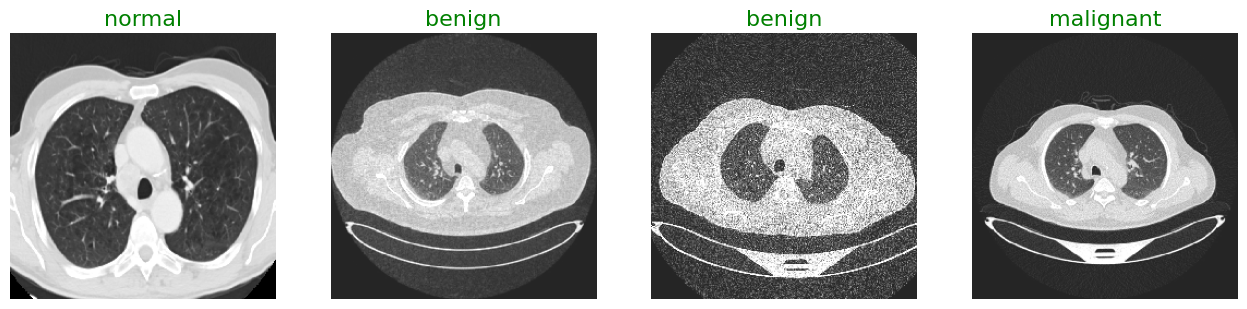

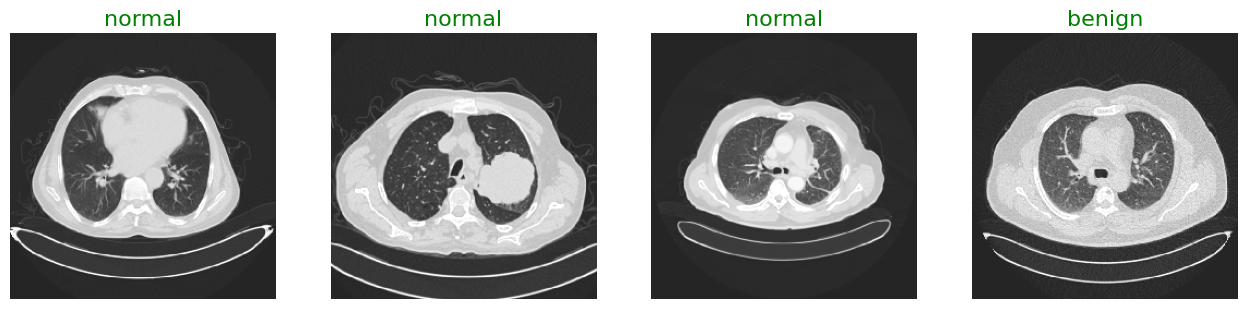

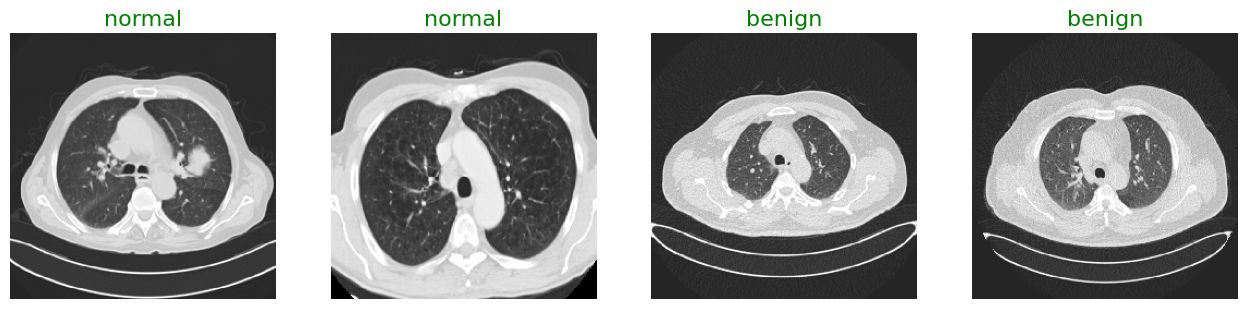

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_images(image_gen):
    classes = list(test.class_indices.keys())
    images, labels = next(image_gen)
    plt.figure(figsize=(20, 20))

    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow((images[i] + 1) / 2)
        plt.title(classes[np.argmax(labels[i])], color="green", fontsize=16)
        plt.axis('off')

    plt.show()

display_sample_images(train)
display_sample_images(test)
display_sample_images(val)

# **3. Building the CNN Model.**

In [ ]:
# PARAMETERS

# for building model
LEARNING_RATE = 0.001
NUM_CLASSES = len(classes)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# saving model data, for training model
MODEL_NUMBER = 2
MODEL_NAME = 'CNN_Model'
MODEL_FULL = MODEL_NAME + '_' + str(MODEL_NUMBER)

In [ ]:
import tensorflow
import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import AvgPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall, AUC

model = Sequential(name="CNN")
model.add(Conv2D(128, (2, 2), padding='same', input_shape=INPUT_SHAPE, activation='relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(2,2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Custom F1 Score metric
@keras.saving.register_keras_serializable()
class F1Score(tensorflow.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tensorflow.keras.metrics.Precision()
        self.recall = tensorflow.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

model.compile(
    loss='categorical_crossentropy',
    optimizer=tensorflow.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy', Recall(), Precision(), F1Score(), AUC()]
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 244, 244, 128)       │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 244, 244, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 122, 122, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 122, 122, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │      29,493,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 32,299,011 (123.21 MB)

 Trainable params: 32,298,115 (123.21 MB)

 Non-trainable params: 896 (3.50 KB)

# **4. Training the CNN Model.**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(MODEL_FULL + '_best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# fit the model - training
history = model.fit(
    train,
    validation_data=val,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint, reduce_lr, tensorboard],
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 50s 206ms/step - accuracy: 0.5280 - auc: 0.6696 - f1_score: 0.5280 - loss: 16.3919 - precision: 0.5280 - recall: 0.5280 - val_accuracy: 0.4136 - val_auc: 0.5602 - val_f1_score: 0.4136 - val_loss: 112.2136 - val_precision: 0.4136 - val_recall: 0.4136 - learning_rate: 0.0010
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 59s 127ms/step - accuracy: 0.6445 - auc: 0.7571 - f1_score: 0.6455 - loss: 5.7328 - precision: 0.6465 - recall: 0.6445 - val_accuracy: 0.5682 - val_auc: 0.7443 - val_f1_score: 0.5682 - val_loss: 2.0613 - val_precision: 0.5682 - val_recall: 0.5682 - learning_rate: 0.0010
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.6875 - auc: 0.8191 - f1_score: 0.6870 - loss: 2.6197 - precision: 0.6891 - recall: 0.6849 - val_accuracy: 0.5591 - val_auc: 0.7589 - val_f1_score: 0.5591 - val_loss: 2.8918 - val_precision: 0.5591 - val_recall: 0.5591 - learning_rate: 0.0010
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step - accuracy: 0.7508 -

## **5.1 Performance Graphs**

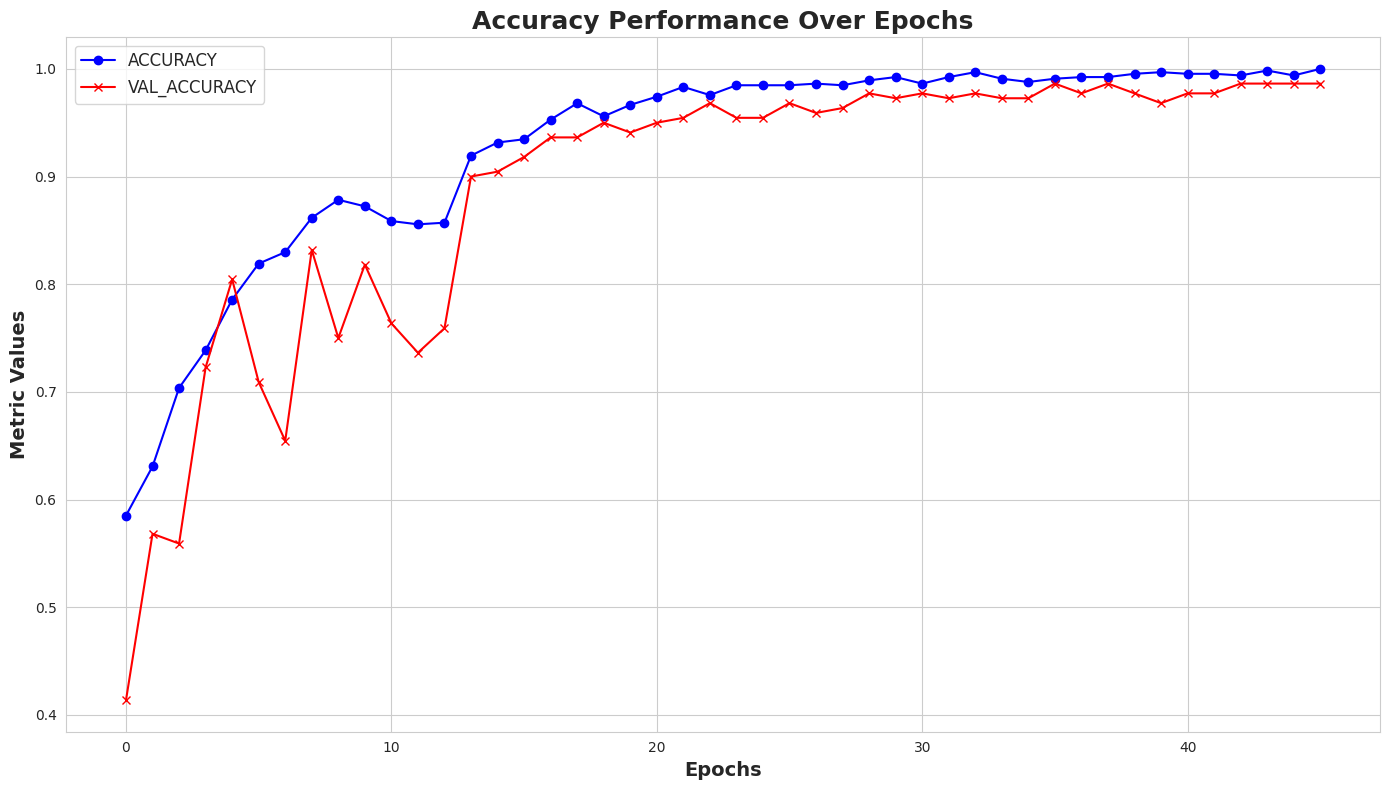

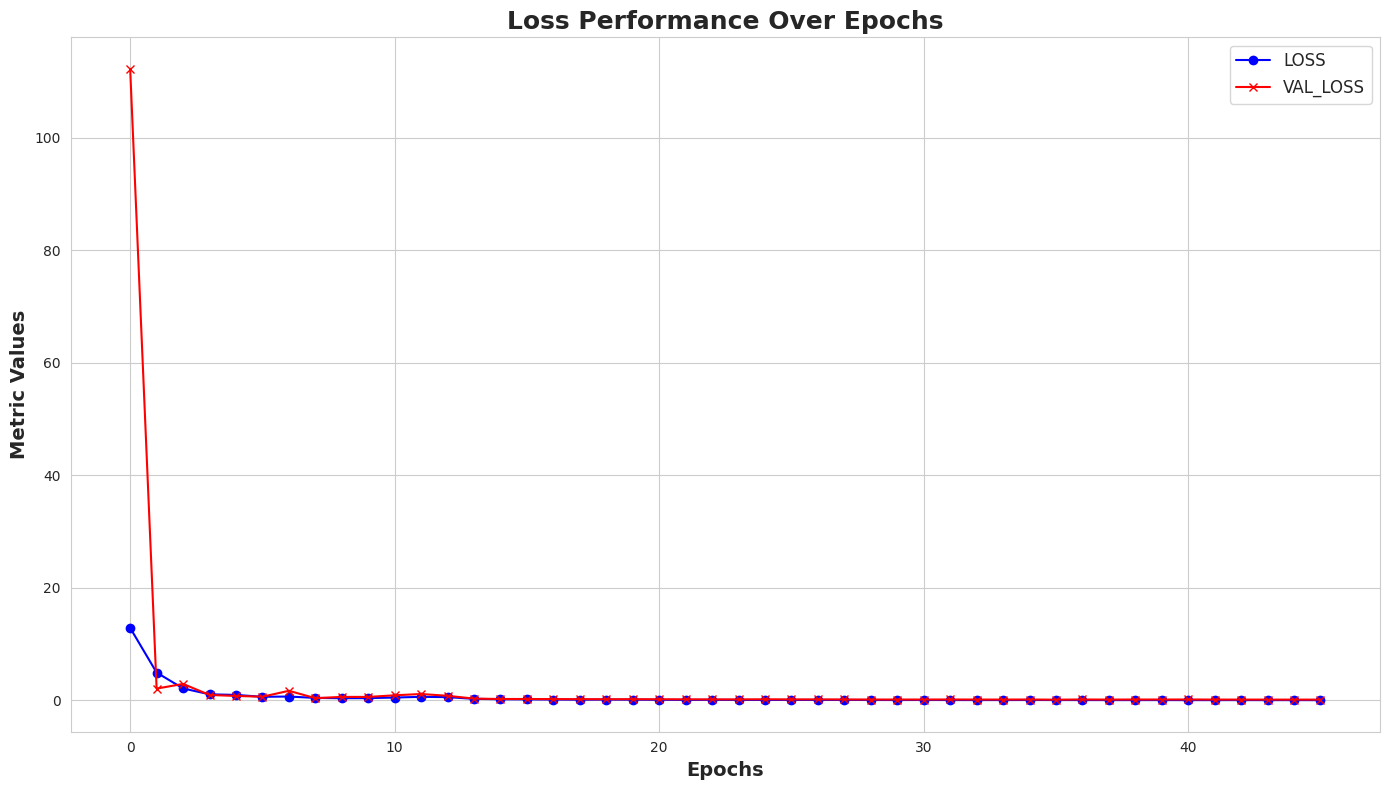

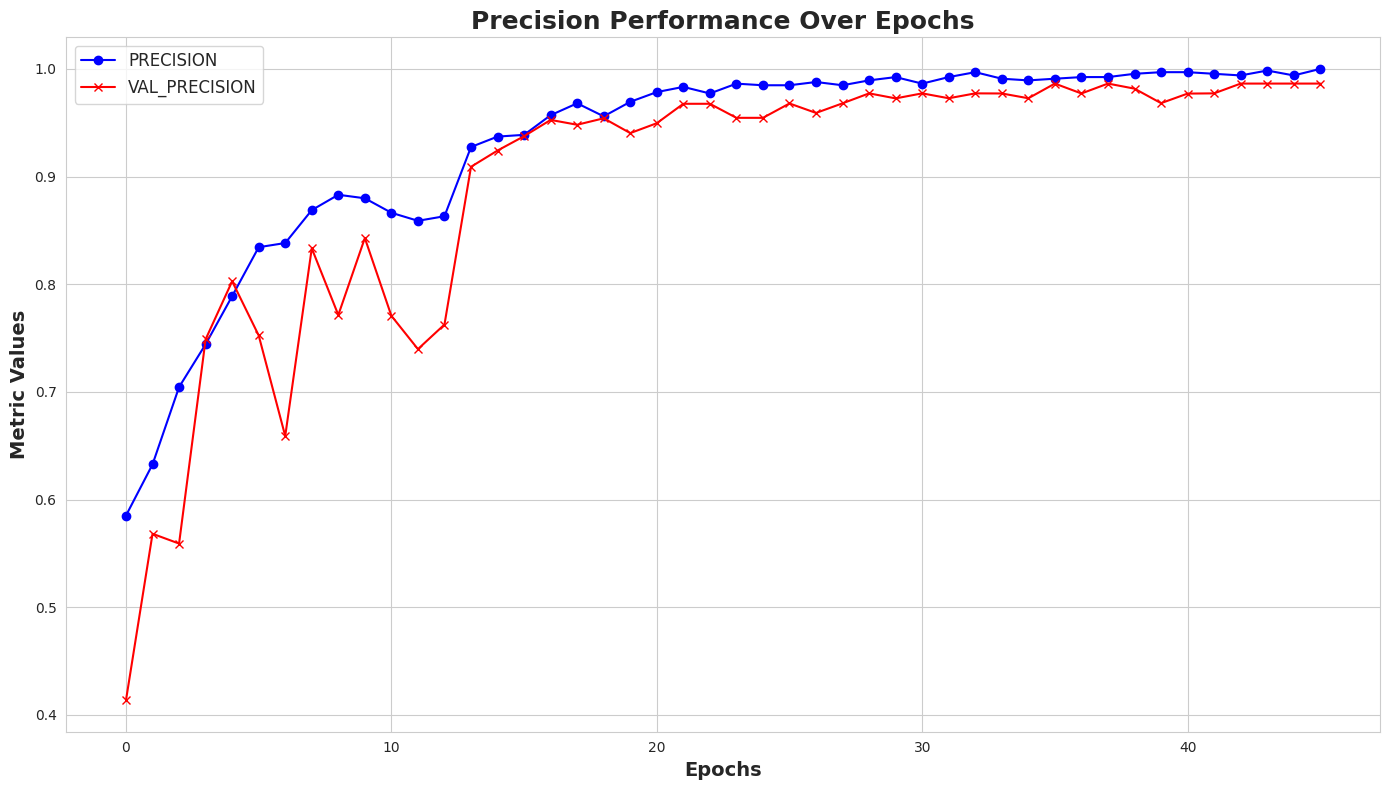

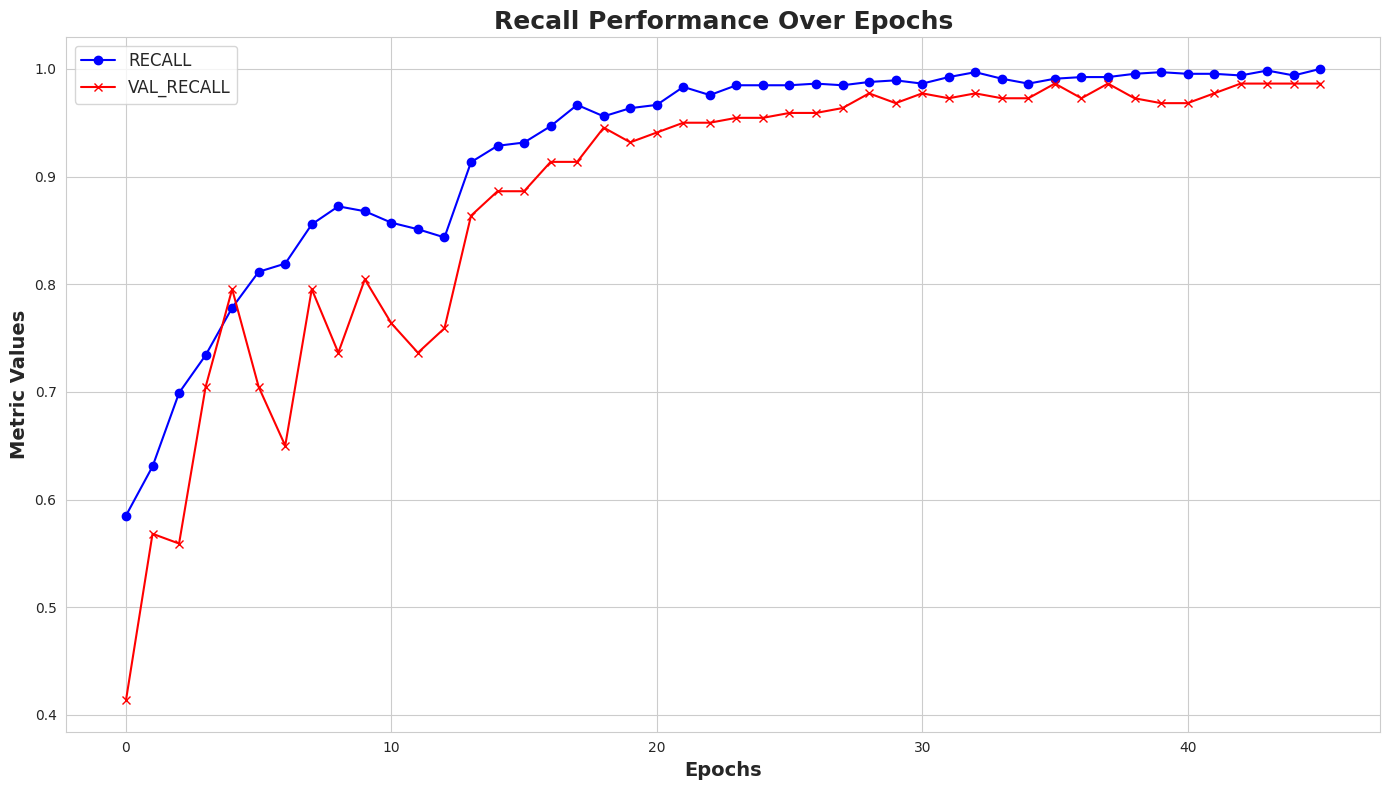

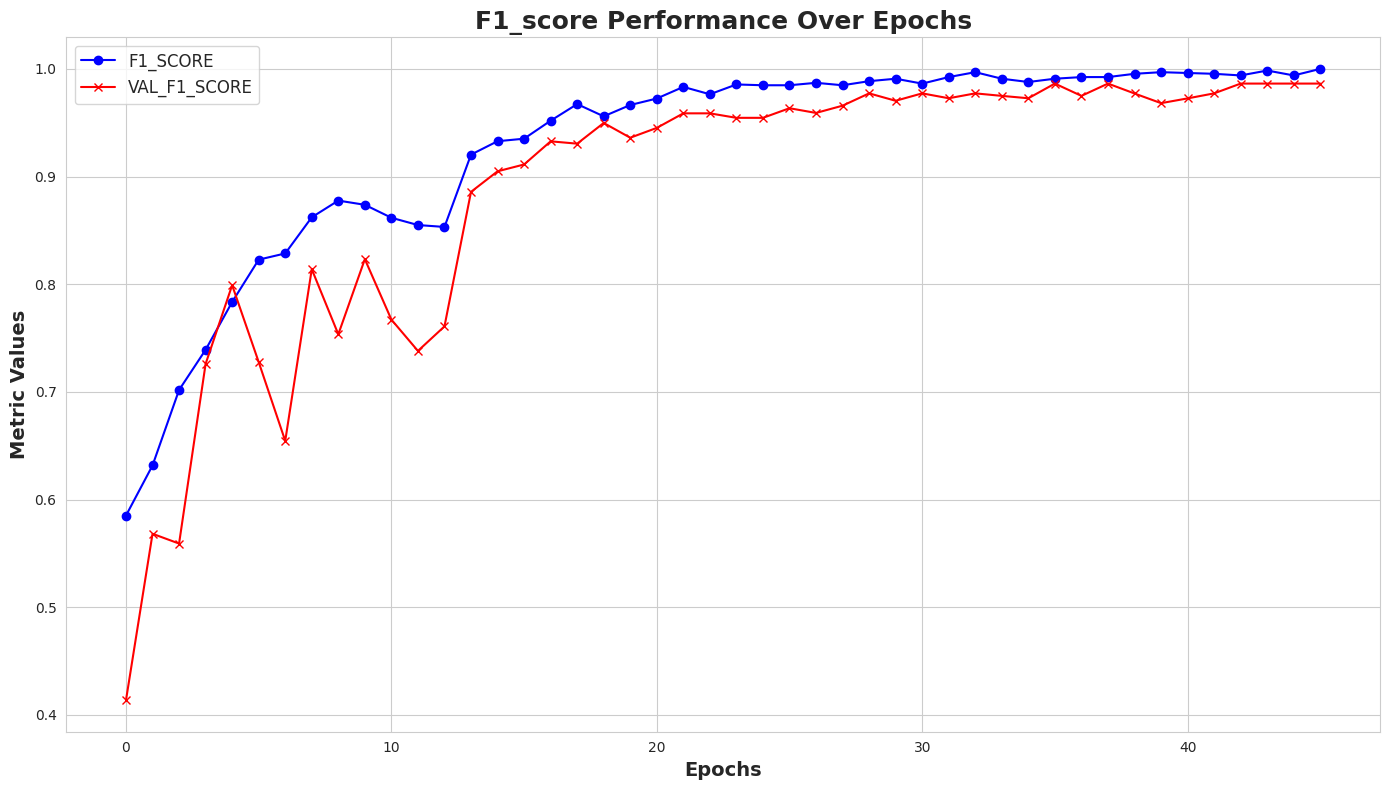

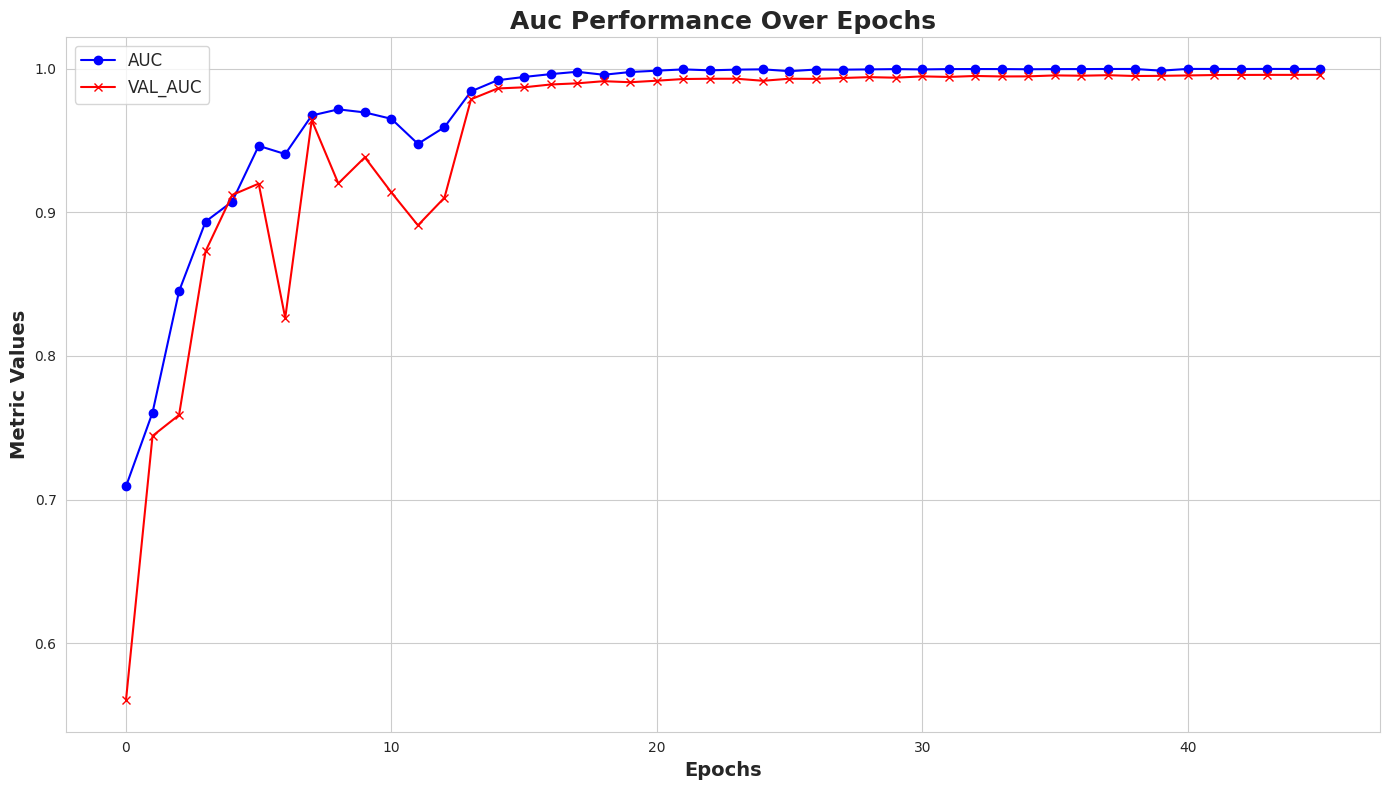

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, metric, title):
    val_metric = "val_" + metric
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 8))
    plt.plot(history.history[metric], label=metric.upper(), linestyle='-', marker='o', color='blue')
    plt.plot(history.history[val_metric], label=val_metric.upper(), linestyle='-', marker='x', color='red')
    plt.xlabel('Epochs', fontsize=14, fontweight='bold')
    plt.ylabel('Metric Values', fontsize=14, fontweight='bold')
    plt.title(metric.capitalize() + title, fontsize=18, fontweight='bold')
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

metrics = ['accuracy', 'loss', 'precision', 'recall', 'f1_score', 'auc']
for metric in metrics:
    print()
    plot_training_history(history, metric, title=' Performance Over Epochs')

# **5. Evaluating the CNN Model.**

In [ ]:
model.save(MODEL_FULL + ".keras")

In [ ]:
from tensorflow.keras.models import load_model

# load the entire model from a .keras file
model = load_model(MODEL_FULL + '.keras')

# evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall, f1_score, test_auc  = model.evaluate(test, verbose=1)

# print the results
print("Test Loss:", test_loss)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-Score: {f1_score}")
print(f"Test AUC: {test_auc}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9935 - auc: 0.9977 - f1_score: 0.9935 - loss: 0.0594 - precision: 0.9935 - recall: 0.9935
Test Loss: 0.1746852844953537
Test Accuracy: 0.9771689772605896
Test Precision: 0.9771689772605896
Test Recall: 0.9771689772605896
Test F1-Score: 0.9771689176559448
Test AUC: 0.9915140271186829


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


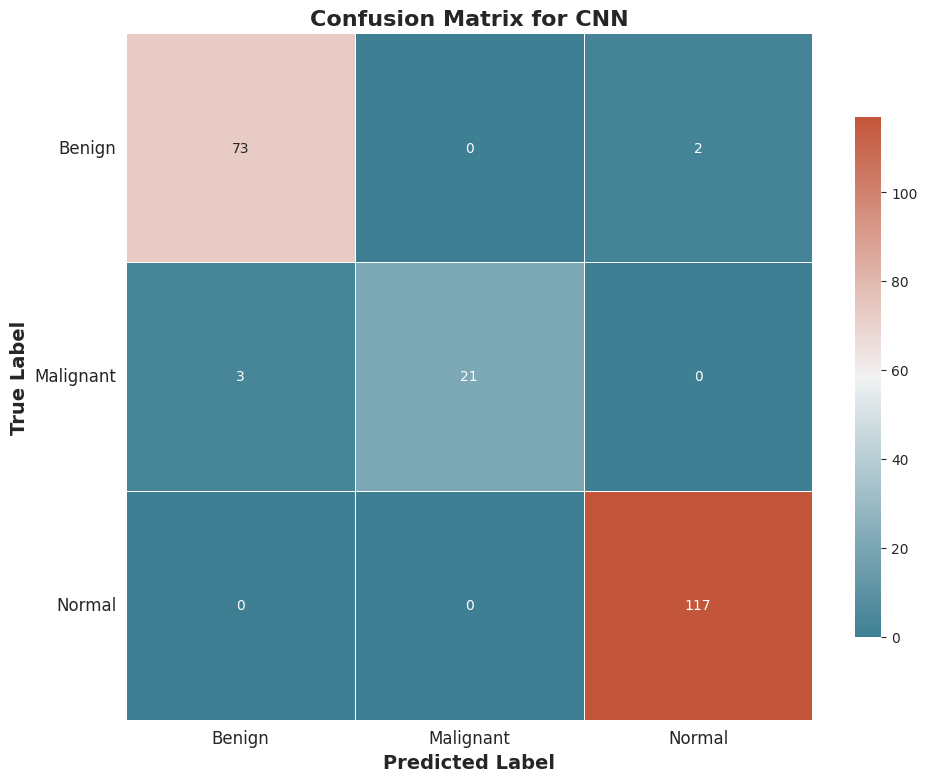

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# predict on the test set
test_steps = test.samples // test.batch_size
y_pred = model.predict(test, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test.classes
y_true = y_true[:len(y_pred)]

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Set the figure size and resolution
plt.figure(figsize=(10, 8), dpi=100)

# Create a custom color map
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the confusion matrix heatmap
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap=cmap,
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75},
    xticklabels=[label.capitalize() for label in test.class_indices.keys()],
    yticklabels=[label.capitalize() for label in test.class_indices.keys()]
)

# Add labels and title with increased font size
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix for CNN', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()
plt.savefig(MODEL_FULL + '_Confusion_Matrix_Heatmap.png', format='png', dpi=300)

In [ ]:
# zip the important folders
!zip -r /content/CNN_Model_2.zip /content/CNN_Model_2.keras
!zip -r /content/CNN_Model_2_best_model.zip /content/CNN_Model_2_best_model.keras
!zip -r /content/CNN_Model_2_logs.zip /content/logs

!mkdir -p /content/drive/MyDrive/Research  # Create the folder if it doesn't exist
!mv /content/CNN_Model_2.zip /content/drive/MyDrive/Research
!mv /content/CNN_Model_2_best_model.zip /content/drive/MyDrive/Research
!mv /content/CNN_Model_2_logs.zip /content/drive/MyDrive/Research
!mv /content/CNN_Model_2_Confusion_Matrix_Heatmap.png /content/drive/MyDrive/Research

  adding: content/CNN_Model_2.keras (deflated 11%)
  adding: content/CNN_Model_2_best_model.keras (deflated 11%)
  adding: content/logs/ (stored 0%)
  adding: content/logs/validation/ (stored 0%)
  adding: content/logs/validation/events.out.tfevents.1730294622.52b9443dc632.989.1.v2 (deflated 80%)
  adding: content/logs/train/ (stored 0%)
  adding: content/logs/train/events.out.tfevents.1730294590.52b9443dc632.989.0.v2 (deflated 70%)
mv: cannot stat '/content/CNN_Model_2_Confusion_Matrix_Heatmap.png': No such file or directory
